# TUR-1431 Incremental sales attrition

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS']=f"/home/jovyan/.config/gcloud/legacy_credentials/{os.getenv('JUPYTERHUB_USER')}/adc.json" 

bq = bigquery.Client(project='gcp-wow-rwds-ai-mmm-prod')
plt.rcParams['axes.grid'] = True


In [2]:
def get_rate(df):
    df['r_tpg_sales'] = df['tpg_sales'] / df['audience']
    df['r_sales'] = df['sales'] / df['audience']
    df['r_inc_sales'] = df['inc_sales'] / df['audience']
    df['r_redeemers'] = df['redeemers'] / df['audience']
    return df

### Total Audience

In [3]:
sql = '''
    SELECT 
        fcs.campaign_start_date, 
        COUNT(DISTINCT fcs.crn) AS audience,
        SUM(fcs.tpg_tot_amt_incld_gst_promo) AS tpg_sales,
        SUM(fcs.tot_amt_incld_gst_promo) AS sales,
        SUM(fcs.attributed_inc_sales) AS inc_sales,
        COUNT(DISTINCT fcs.redeem_flag) AS redeemers
    FROM `gcp-wow-rwds-ai-data-prod.loyalty_car_analytics.fact_campaign_sales_solus_view` fcs
        JOIN `gcp-wow-rwds-ai-mmm-prod.PROD_MMM_CAT.MMM_AUDIENCE_MASTER` ma
            ON fcs.crn = ma.crn
            AND fcs.campaign_code = ma.campaign_code || '-' || ma.campaign_type
            AND fcs.campaign_start_date = DATE(ma.campaign_start_date)
    WHERE ma.Campaign_Seg_Grp_Id != 'None'
    GROUP BY 1
    ORDER BY 1;
'''

df_total = bq.query(sql).result().to_dataframe()

In [4]:
df_total = get_rate(df_total)

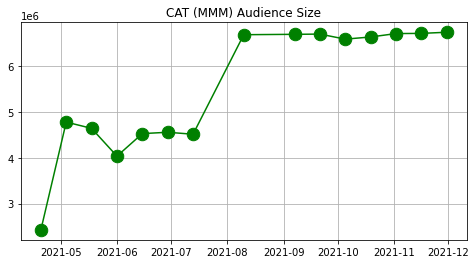

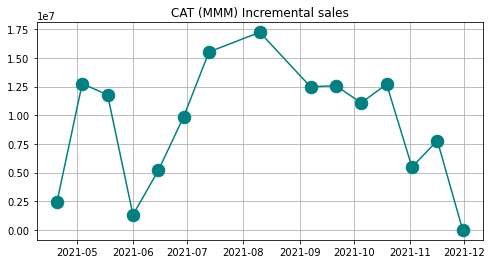

In [5]:
fig = plt.figure(figsize=(8,4))
plt.title('CAT (MMM) Audience Size')
plt.plot(df_total.campaign_start_date, df_total.audience, '.-g', ms=25, label='audience size')
plt.show()
fig = plt.figure(figsize=(8,4))
plt.title('CAT (MMM) Incremental sales')
plt.plot(df_total.campaign_start_date, df_total.inc_sales, '.-', color='teal', ms=25, label='audience size')
plt.show()

### Overall numbers

/home/jovyan/my-conda-envs/sandbox/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  import sys


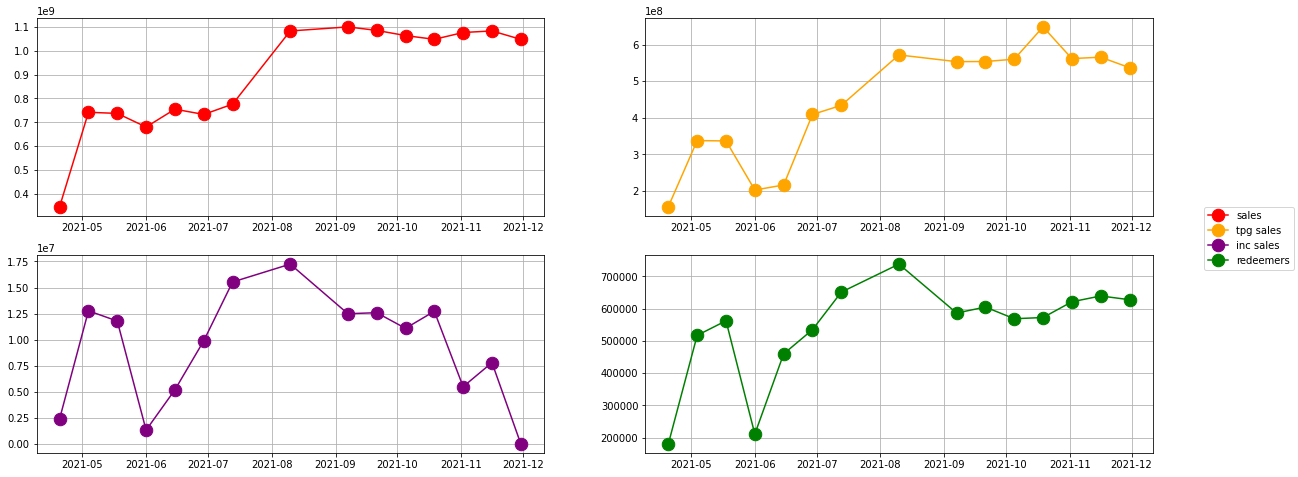

In [6]:
fig, ax = plt.subplots(2,2, figsize=(20,8))
ax[0,0].plot(df_total.campaign_start_date, df_total.sales, '.-', color='red', ms=25)
ax[0,1].plot(df_total.campaign_start_date, df_total.tpg_sales, '.-', color='orange', ms=25)
ax[1,0].plot(df_total.campaign_start_date, df_total.inc_sales, '.-', color='purple', ms=25)
ax[1,1].plot(df_total.campaign_start_date, df_total.redeemers, '.-', color='green', ms=25)
labels = ['sales', 'tpg sales', 'inc sales', 'redeemers']
fig.legend(ax, labels=labels, loc="right")
plt.show()

### Overall rates

/home/jovyan/my-conda-envs/sandbox/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  import sys


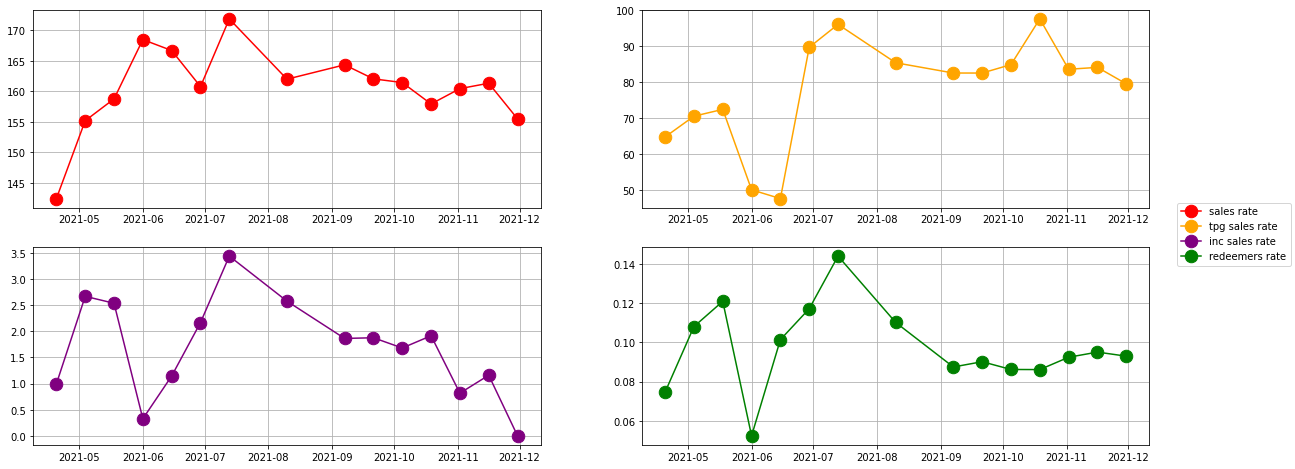

In [7]:
fig, ax = plt.subplots(2,2, figsize=(20,8))
ax[0,0].plot(df_total.campaign_start_date, df_total.r_sales, '.-', color='red', ms=25)
ax[0,1].plot(df_total.campaign_start_date, df_total.r_tpg_sales, '.-', color='orange', ms=25)
ax[1,0].plot(df_total.campaign_start_date, df_total.r_inc_sales, '.-', color='purple', ms=25)
ax[1,1].plot(df_total.campaign_start_date, df_total.r_redeemers, '.-', color='green', ms=25)
labels = ['sales rate', 'tpg sales rate', 'inc sales rate', 'redeemers rate']
fig.legend(ax, labels=labels, loc="right")
plt.show()

### Weekly view

In [8]:
sql = '''
    SELECT 
        fcs.offer_start_date,
        COUNT(DISTINCT fcs.crn) AS audience,
        SUM(fcs.tpg_tot_amt_incld_gst_promo) AS tpg_sales,
        SUM(fcs.tot_amt_incld_gst_promo) AS sales,
        SUM(fcs.attributed_inc_sales) AS inc_sales,
        COUNT(DISTINCT fcs.redeem_flag) AS redeemers
    FROM `gcp-wow-rwds-ai-data-prod.loyalty_car_analytics.fact_campaign_sales_solus_view` fcs
        JOIN `gcp-wow-rwds-ai-mmm-prod.PROD_MMM_CAT.MMM_AUDIENCE_MASTER` ma
            ON fcs.crn = ma.crn
            AND fcs.campaign_code = ma.campaign_code || '-' || ma.campaign_type
            AND fcs.campaign_start_date = DATE(ma.campaign_start_date)
    WHERE ma.Campaign_Seg_Grp_Id != 'None'
        -- AND fcs.campaign_start_date >= '2021-08-01'
    GROUP BY 1
    ORDER BY 1
'''

df_week = bq.query(sql).result().to_dataframe()

In [9]:
df_week = get_rate(df_week)

/home/jovyan/my-conda-envs/sandbox/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  import sys


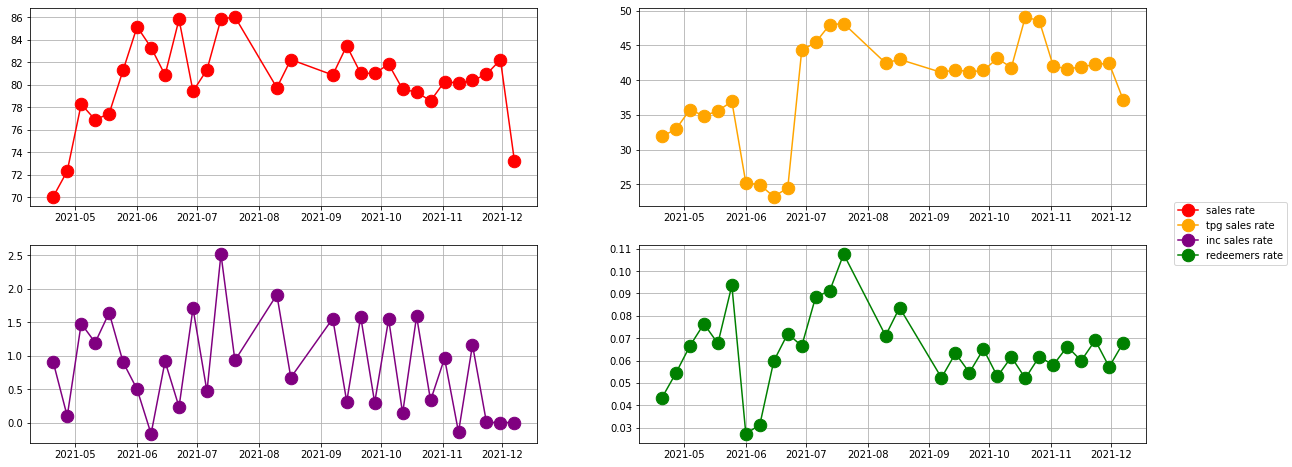

In [10]:
fig, ax = plt.subplots(2,2, figsize=(20,8))
ax[0,0].plot(df_week.offer_start_date, df_week.r_sales, '.-', color='red', ms=25)
ax[0,1].plot(df_week.offer_start_date, df_week.r_tpg_sales, '.-', color='orange', ms=25)
ax[1,0].plot(df_week.offer_start_date, df_week.r_inc_sales, '.-', color='purple', ms=25)
ax[1,1].plot(df_week.offer_start_date, df_week.r_redeemers, '.-', color='green', ms=25)
labels = ['sales rate', 'tpg sales rate', 'inc sales rate', 'redeemers rate']
fig.legend(ax, labels=labels, loc="right")
plt.show()

### Model vs Random

In [11]:
sql = '''
    SELECT 
        fcs.campaign_start_date, 
        ma.Model,
        COUNT(DISTINCT fcs.crn) AS audience,
        SUM(fcs.tpg_tot_amt_incld_gst_promo) AS tpg_sales,
        SUM(fcs.tot_amt_incld_gst_promo) AS sales,
        SUM(fcs.attributed_inc_sales) AS inc_sales,
        COUNT(DISTINCT fcs.redeem_flag) AS redeemers
    FROM `gcp-wow-rwds-ai-data-prod.loyalty_car_analytics.fact_campaign_sales_solus_view` fcs
        JOIN `gcp-wow-rwds-ai-mmm-prod.PROD_MMM_CAT.MMM_AUDIENCE_MASTER` ma
            ON fcs.crn = ma.crn
            AND fcs.campaign_code = ma.campaign_code || '-' || ma.campaign_type
            AND fcs.campaign_start_date = DATE(ma.campaign_start_date)
    WHERE ma.Campaign_Seg_Grp_Id != 'None'
    GROUP BY 1,2
    ORDER BY 1,2;
'''

df_mr = bq.query(sql).result().to_dataframe()

In [12]:
df_mr = get_rate(df_mr)
df_m = df_mr[df_mr.Model == 'M']
df_r = df_mr[df_mr.Model == 'R']

/home/jovyan/my-conda-envs/sandbox/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  """


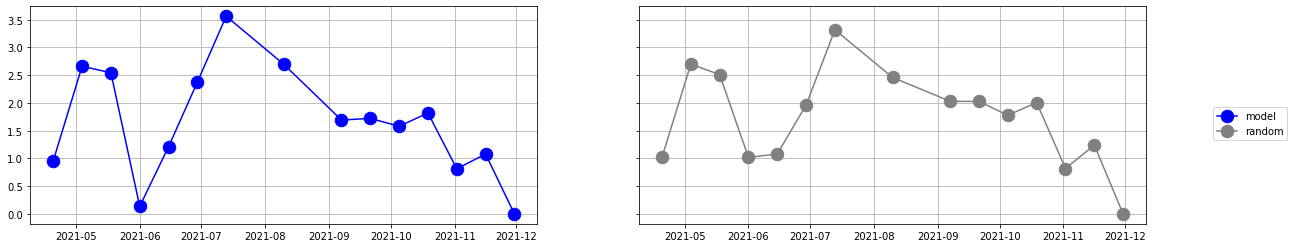

In [13]:
fig, ax = plt.subplots(1,2, figsize=(20,4), sharey=True)
ax[0].plot(df_m.campaign_start_date, df_m.r_inc_sales, '.-', color='blue', ms=25)
ax[1].plot(df_r.campaign_start_date, df_r.r_inc_sales, '.-', color='grey', ms=25)
labels = ['model', 'random']
fig.legend(ax, labels=labels, loc="right")
plt.show()

### Incremental sales ratio by categories

In [14]:
sql = '''
    SELECT 
        ma.Campaign_Seg_Grp_Id,
        fcs.campaign_start_date,
        COUNT(DISTINCT fcs.crn) AS audience,
        SUM(fcs.tpg_tot_amt_incld_gst_promo) AS tpg_sales,
        SUM(fcs.tot_amt_incld_gst_promo) AS sales,
        SUM(fcs.attributed_inc_sales) AS inc_sales,
        COUNT(DISTINCT fcs.redeem_flag) AS redeemers
    FROM `gcp-wow-rwds-ai-data-prod.loyalty_car_analytics.fact_campaign_sales_solus_view` fcs
        JOIN `gcp-wow-rwds-ai-mmm-prod.PROD_MMM_CAT.MMM_AUDIENCE_MASTER` ma
            ON fcs.crn = ma.crn
            AND fcs.campaign_code = ma.campaign_code || '-' || ma.campaign_type
            AND fcs.campaign_start_date = DATE(ma.campaign_start_date)
    WHERE ma.Campaign_Seg_Grp_Id != 'None'
        -- AND fcs.campaign_start_date >= '2021-08-01'
    GROUP BY 1,2
    ORDER BY 1,2
'''

df = bq.query(sql).result().to_dataframe()

In [15]:
df = get_rate(df)
df['ratio'] = df['r_inc_sales'] / df['r_sales']

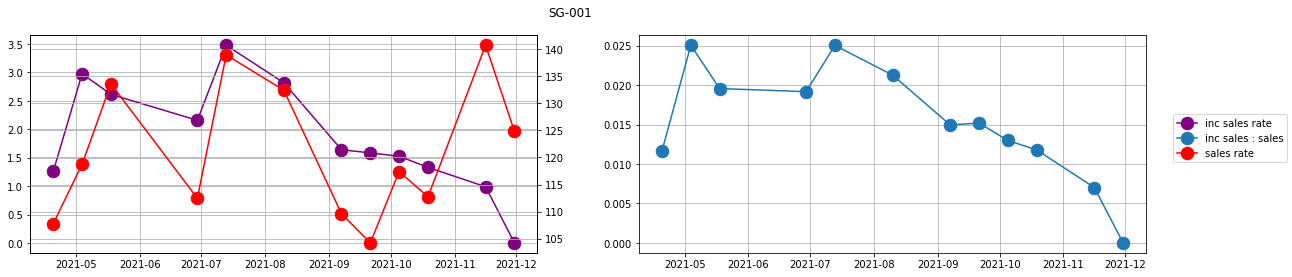

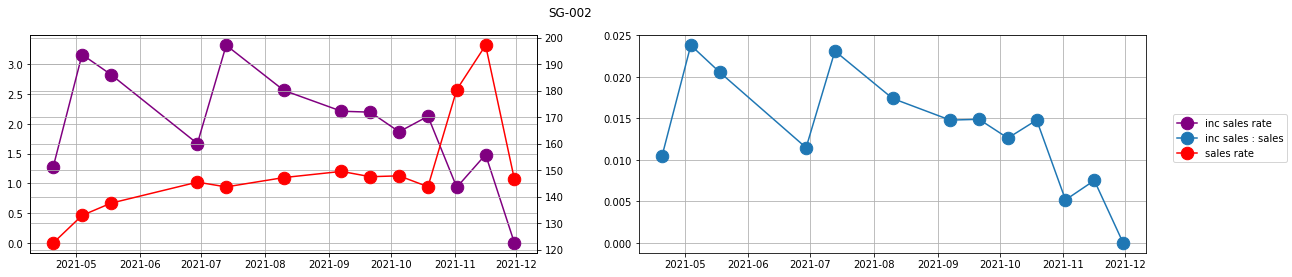

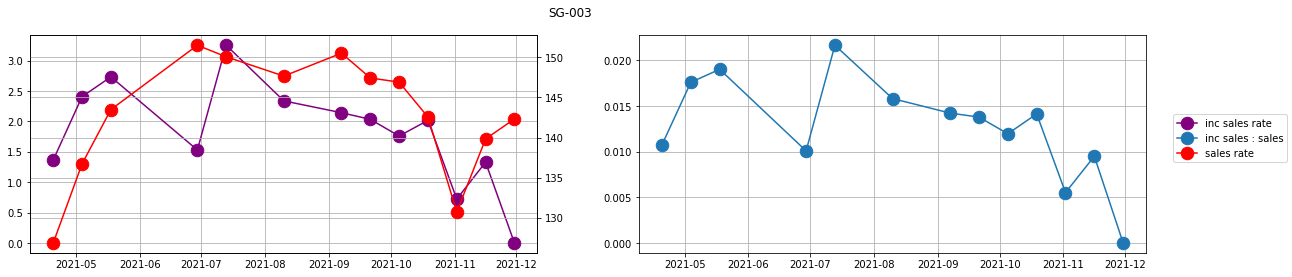

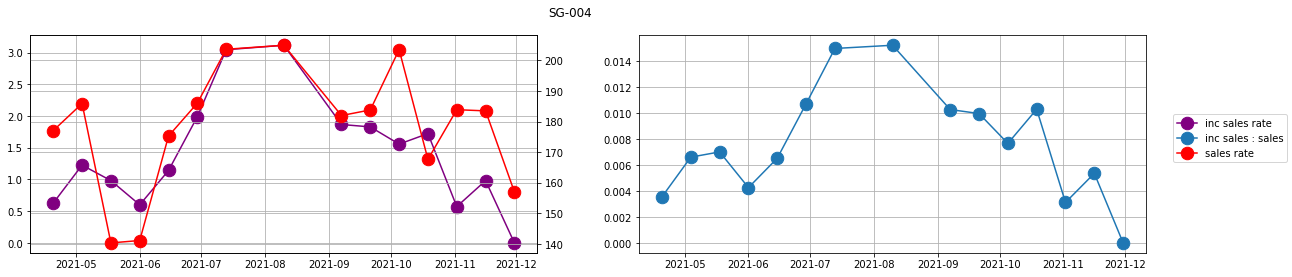

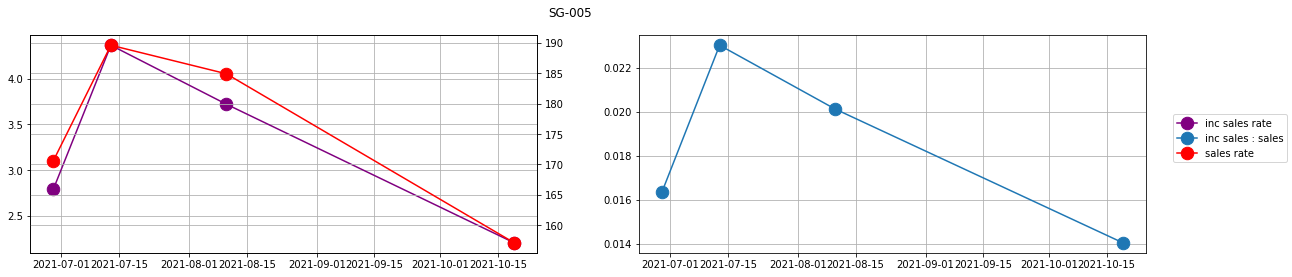

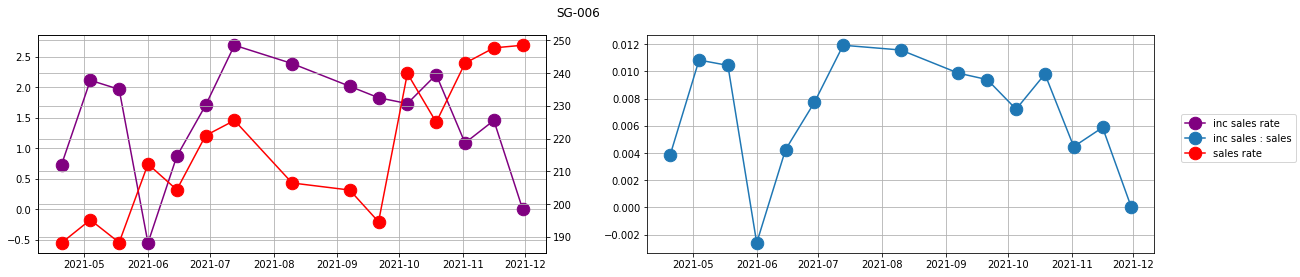

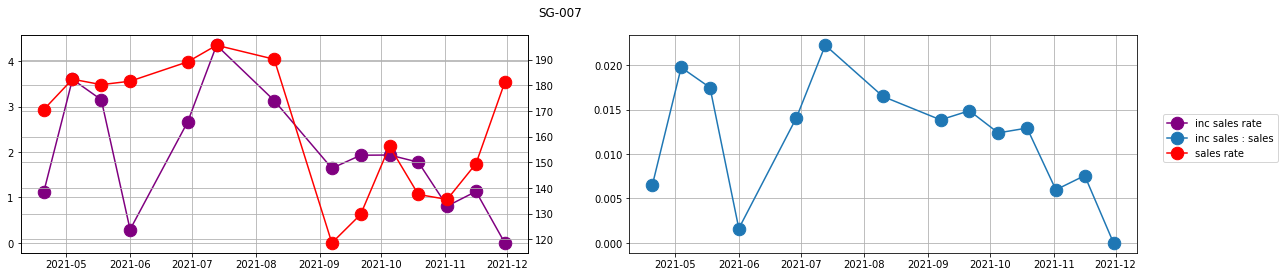

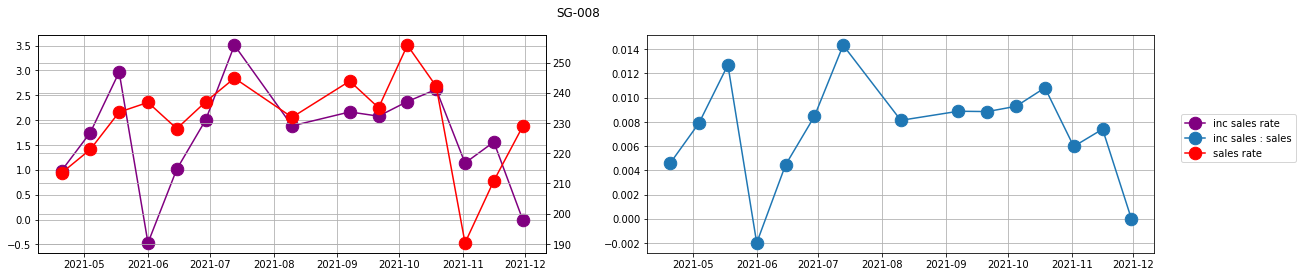

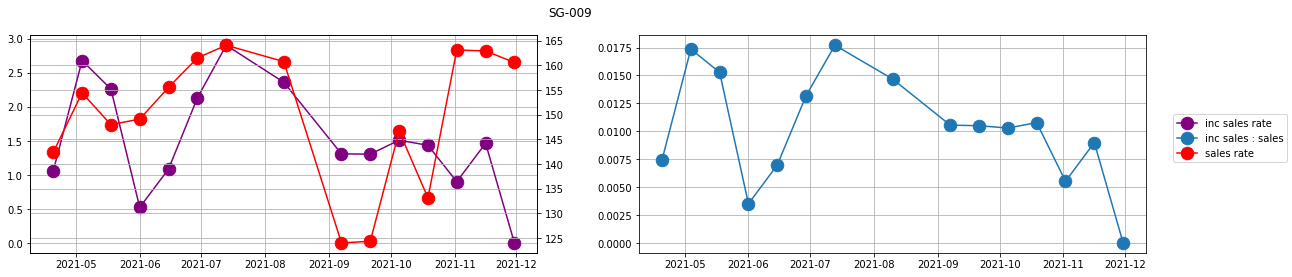

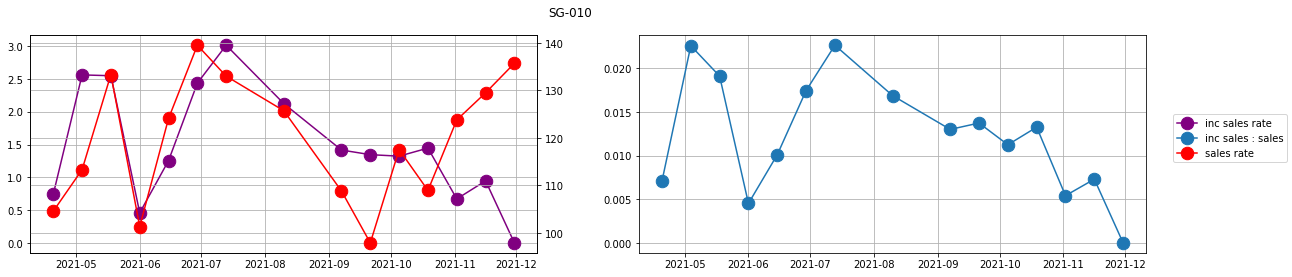

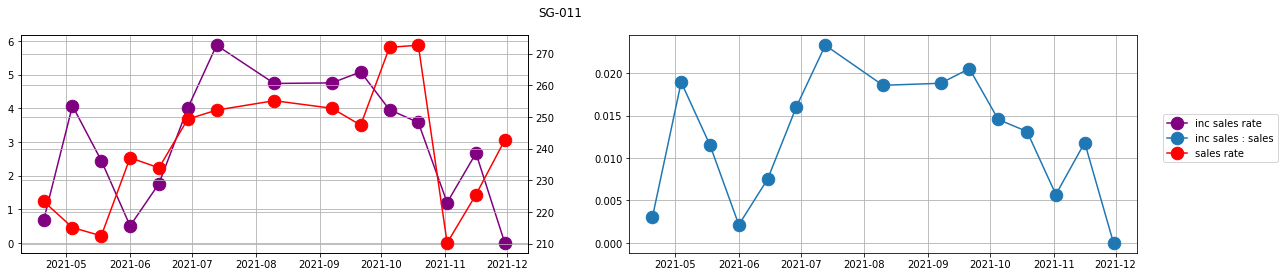

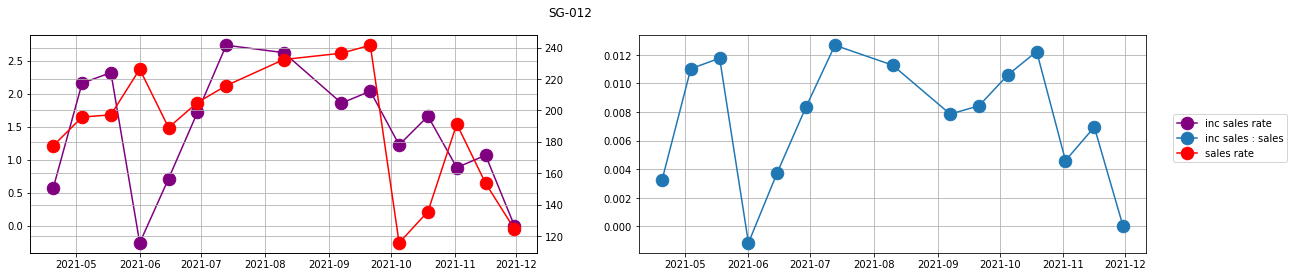

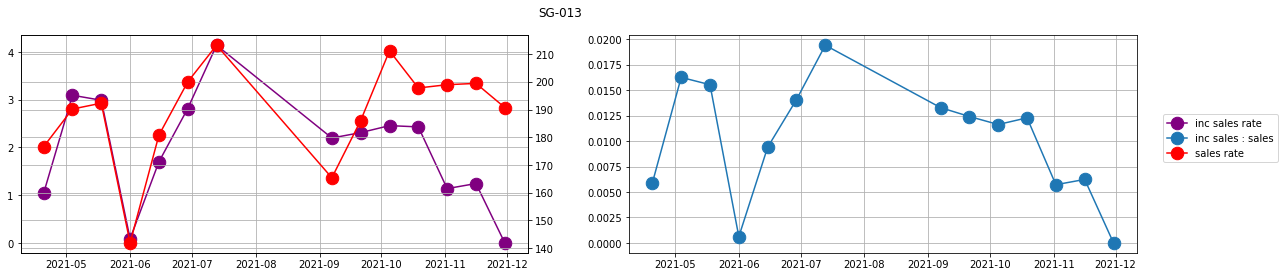

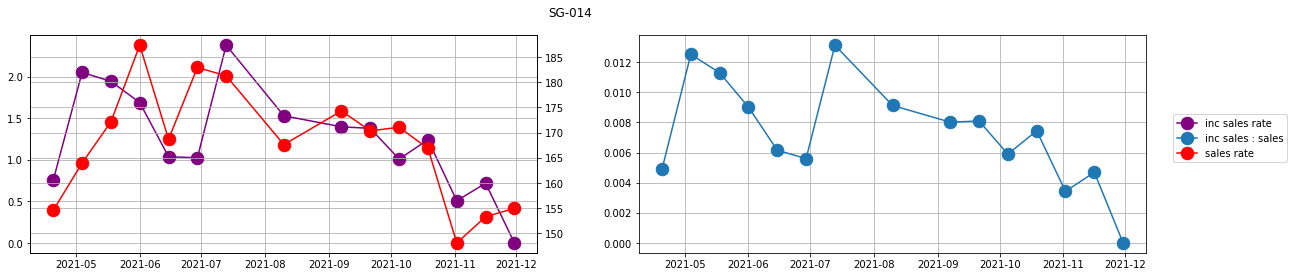

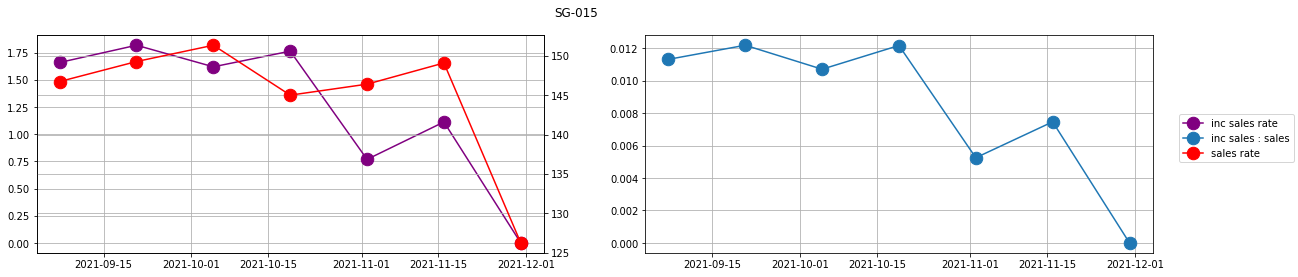

In [16]:
labels = df.Campaign_Seg_Grp_Id.unique()
for i, cmpgn in enumerate(labels):
    df_cmpgn = df[df.Campaign_Seg_Grp_Id == cmpgn]
    fig, ax = plt.subplots(1,2,figsize=(20,4))
    ax[0].plot(df_cmpgn.campaign_start_date, df_cmpgn.r_inc_sales, '.-', color='purple', ms=25, label='inc sales rate')
    ax2 = ax[0].twinx()
    ax2.plot(df_cmpgn.campaign_start_date, df_cmpgn.r_sales, '.-', color='red', ms=25, label='sales rate')
    ax[1].plot(df_cmpgn.campaign_start_date, df_cmpgn.ratio, '.-', ms=25, label = 'inc sales : sales')
    plt.suptitle(cmpgn)
    fig.legend(loc='right')
    plt.show()

### Campaign attribution

In [17]:
sql = '''
    WITH cat AS (
        SELECT DISTINCT crn, fw_start_date
        FROM `gcp-wow-rwds-ai-data-prod.loyalty_car_analytics.cp_att_crn_all_view` 
        WHERE campaign_code IN ('CAT-4298-MP', 'CAT-4298-SS')
    )
    SELECT 
        cpa.fw_start_date, 
        SUM(CASE WHEN campaign_code IN ('CAT-4298-MP', 'CAT-4298-SS') THEN cpa.attributed_inc_sales ELSE 0 END) cat_inc_sales,
        SUM(cpa.attributed_inc_sales) total_inc_sales
    FROM `gcp-wow-rwds-ai-data-prod.loyalty_car_analytics.cp_att_crn_all_view` cpa 
        JOIN cat ON cpa.crn = cat.crn AND cpa.fw_start_date = cat.fw_start_date
    GROUP BY 1 ORDER BY 1
'''

df_attr = bq.query(sql).result().to_dataframe()

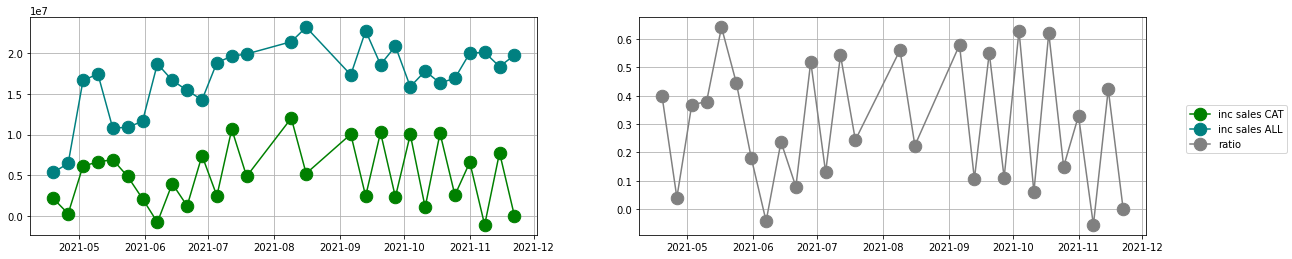

In [18]:
fig, ax = plt.subplots(1,2,figsize=(20,4))
ax[0].plot(df_attr.fw_start_date, df_attr.cat_inc_sales, '.-', color='green', ms=25, label='inc sales CAT')
ax[0].plot(df_attr.fw_start_date, df_attr.total_inc_sales, '.-', color='teal', ms=25, label='inc sales ALL')
ax[1].plot(df_attr.fw_start_date, df_attr.cat_inc_sales / df_attr.total_inc_sales, '.-', color='grey', ms=25, label = 'ratio')
fig.legend(loc='right')
plt.show()